In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# data on papers with fewer than 200 citations
data = pd.read_csv('data/articles_features.csv')[['AvgAuthorRank', 
                                                  'AvgAffiliationRank', 
                                                  'JournalRank', 
                                                  'CitationCount']].query('CitationCount<=200')
data['HighlyCited'] = (data['CitationCount'] > 50).astype('int')

<ipython-input-2-51ab7565d395>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [2]:
# display features
data

,AvgAuthorRank,AvgAffiliationRank,JournalRank,CitationCount,HighlyCited
0,16262.500000,6986.000000,9402,17,0
1,17044.857143,4975.285714,9402,65,1
2,16440.000000,5885.875000,9402,13,0
3,15818.750000,6697.750000,9402,47,0
4,15339.769231,6246.076923,9402,8,0
...,...,...,...,...,...
79936,15795.500000,4441.000000,11029,7,0
79937,17387.923077,9013.307692,11029,12,0
79938,15961.125000,4925.000000,11029,53,1
79939,16805.500000,8253.000000,11029,17,0


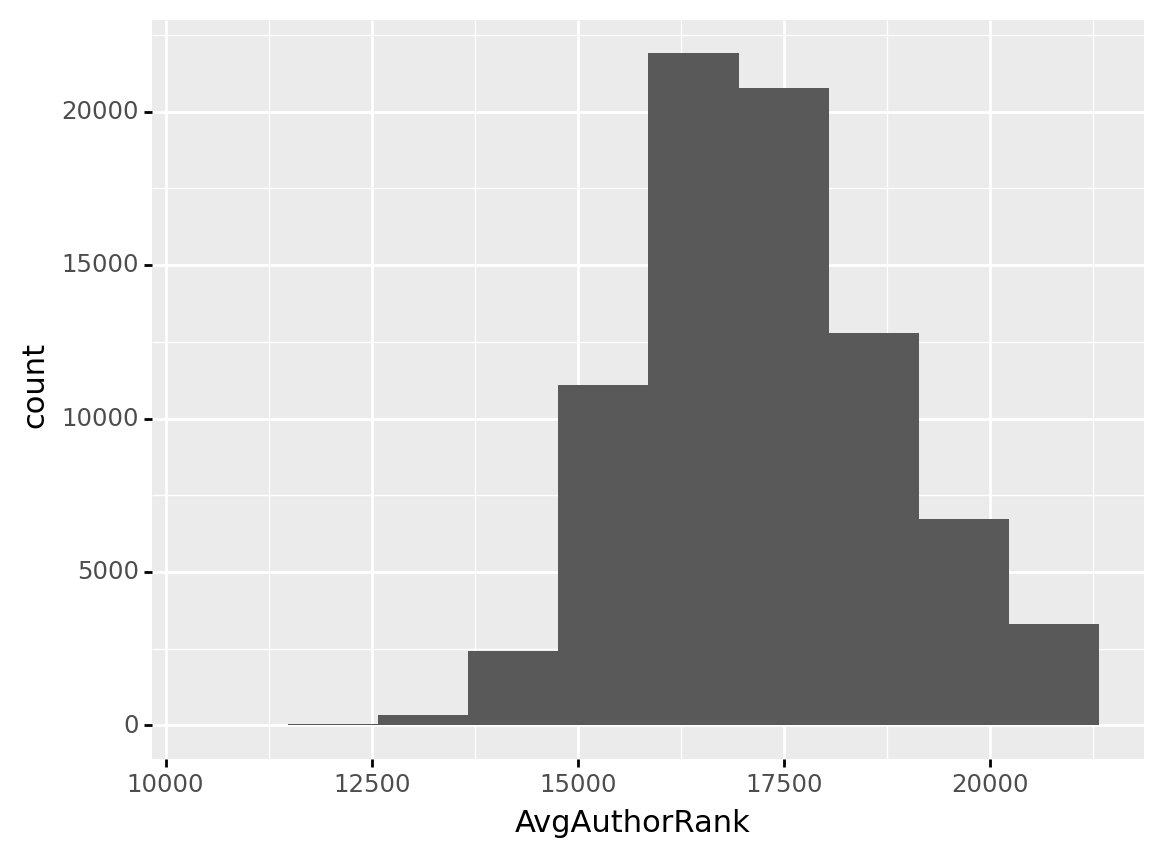

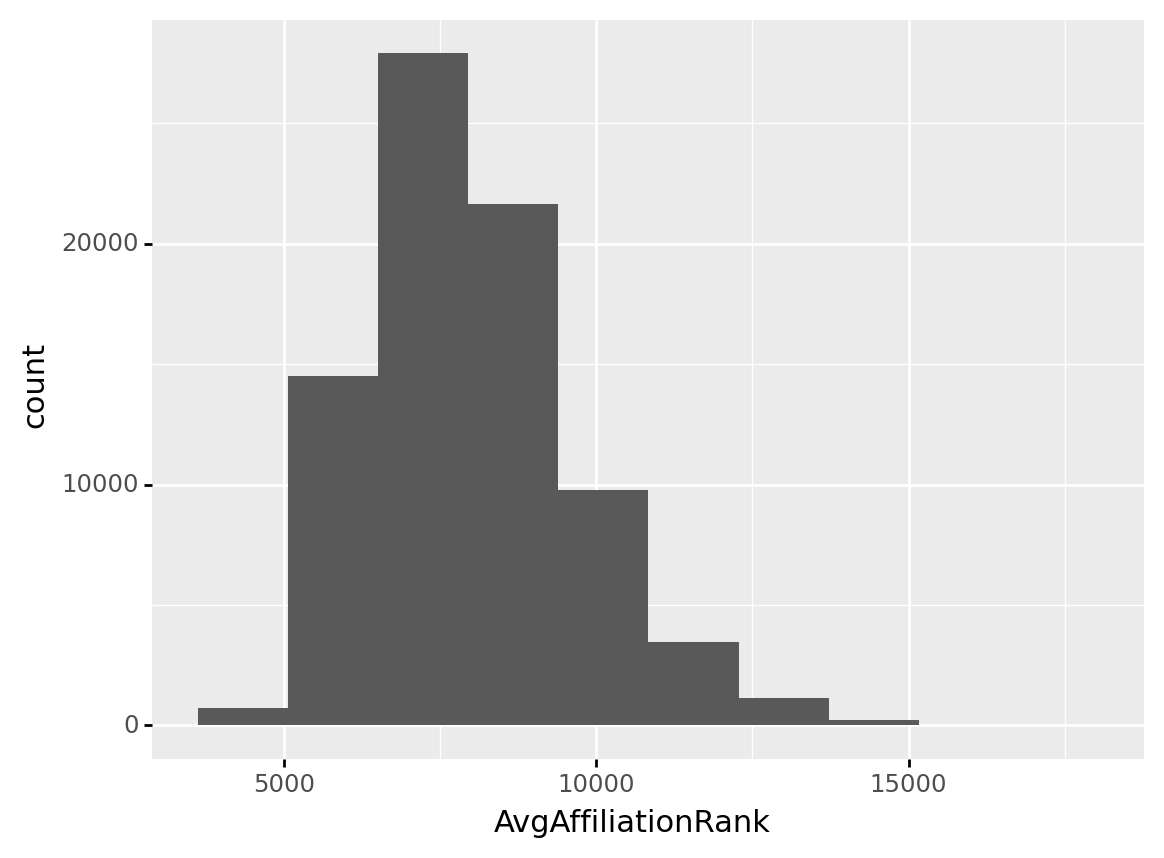

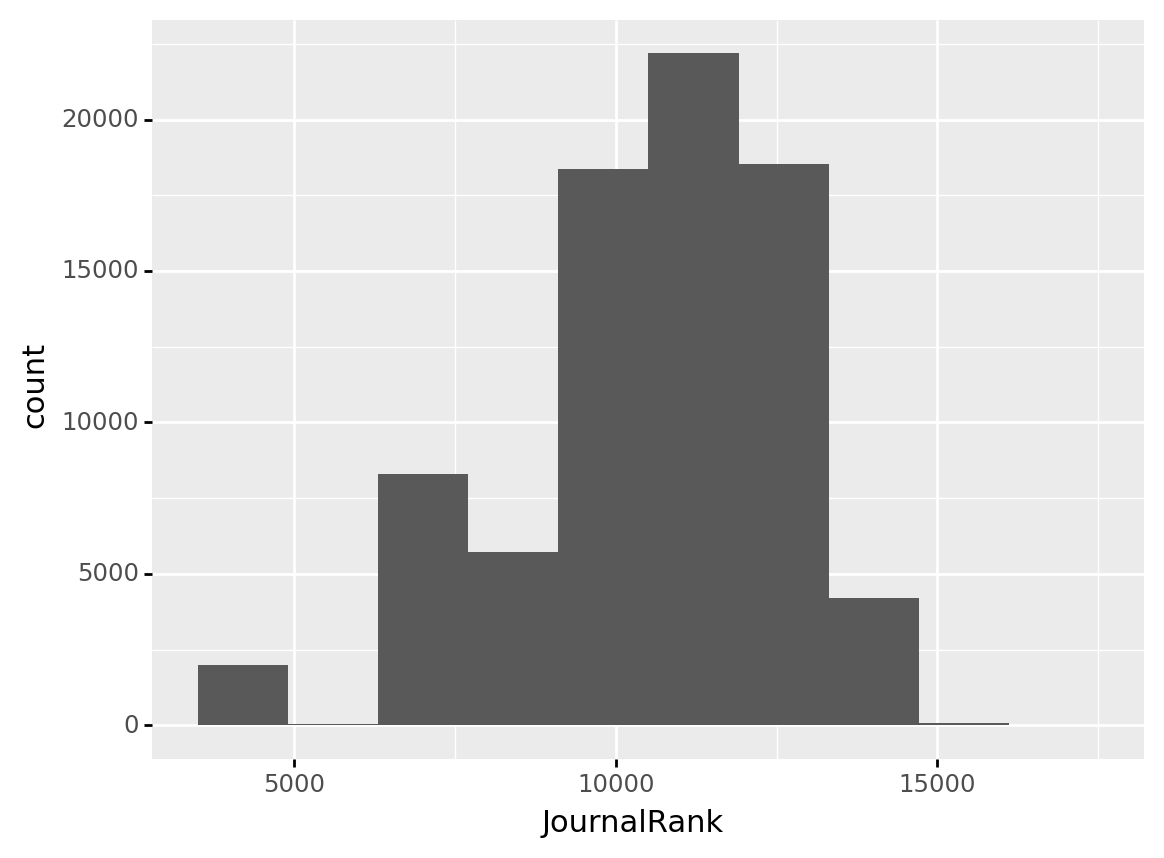

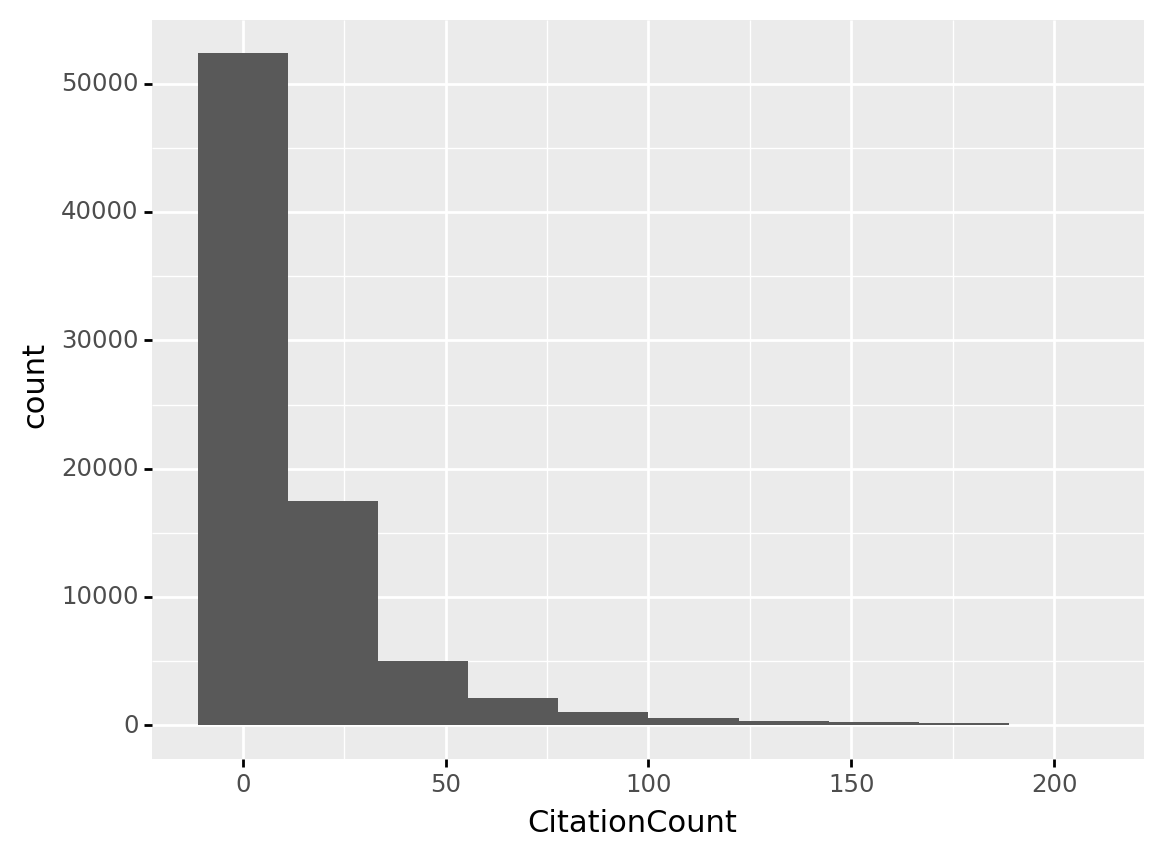

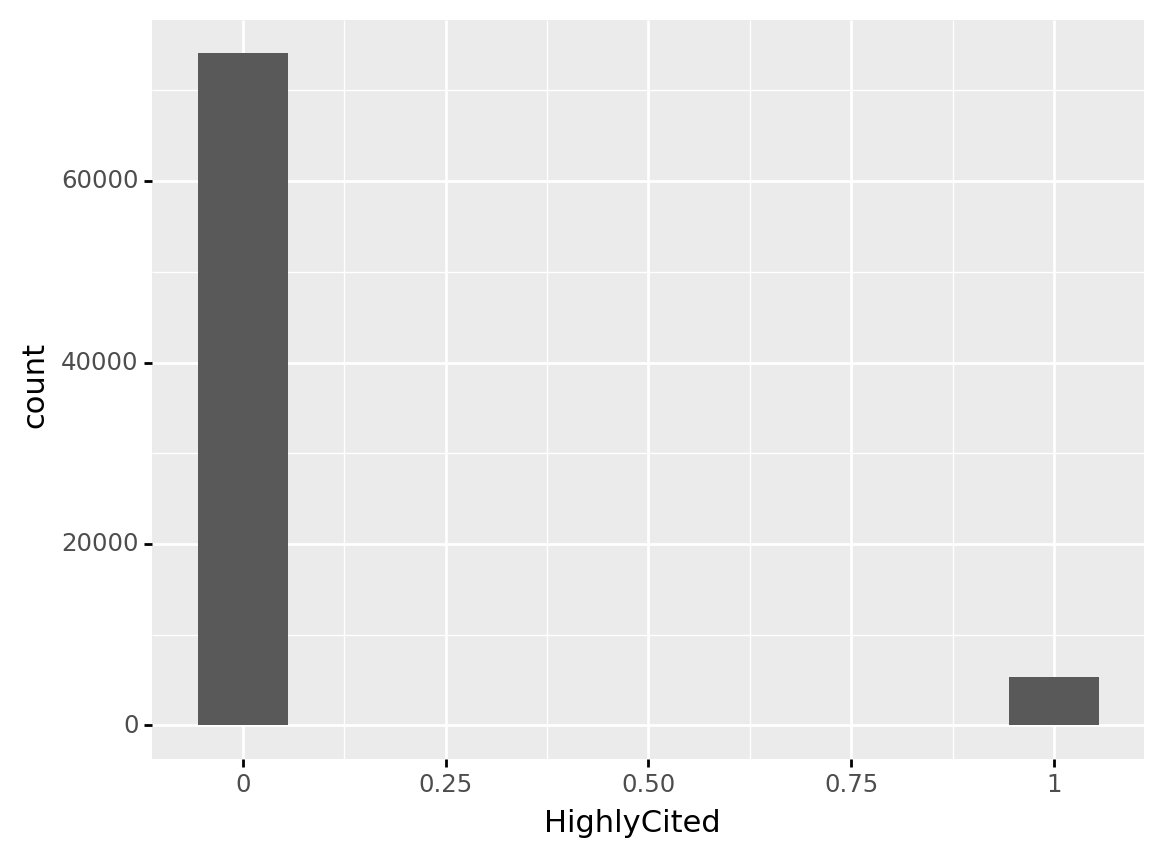

[<ggplot: (8751108827314)>,
 <ggplot: (8751108824709)>,
 <ggplot: (8751108819556)>,
 <ggplot: (8751108821420)>,
 <ggplot: (8751109110917)>]

In [3]:
# histogram of the features
[ggplot(aes(x=col), data=data) + geom_histogram(bins=10) for col in data.columns]

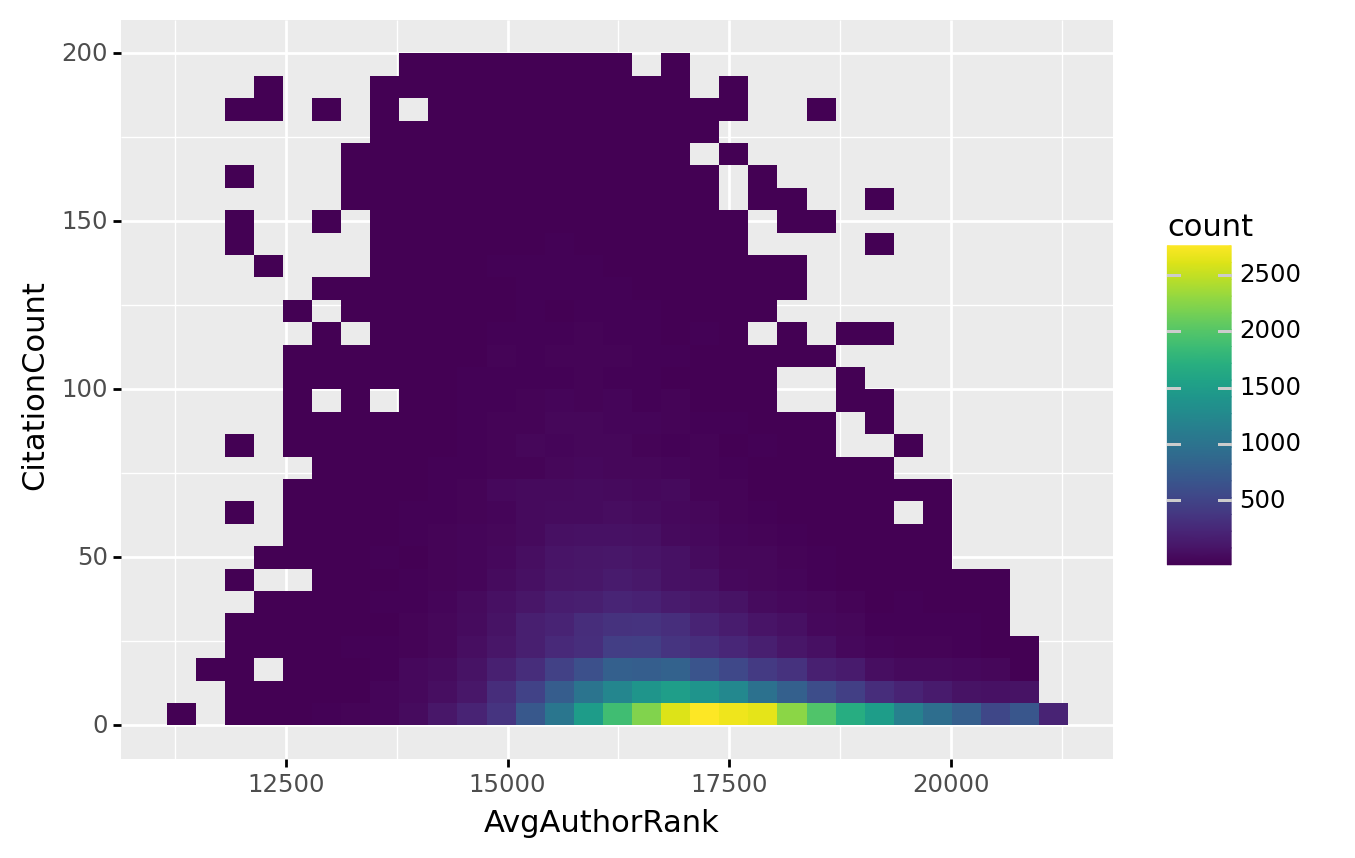

<ggplot: (8751108885396)>

In [4]:
ggplot(aes(x='AvgAuthorRank', y='CitationCount'), data=data) + stat_bin2d()

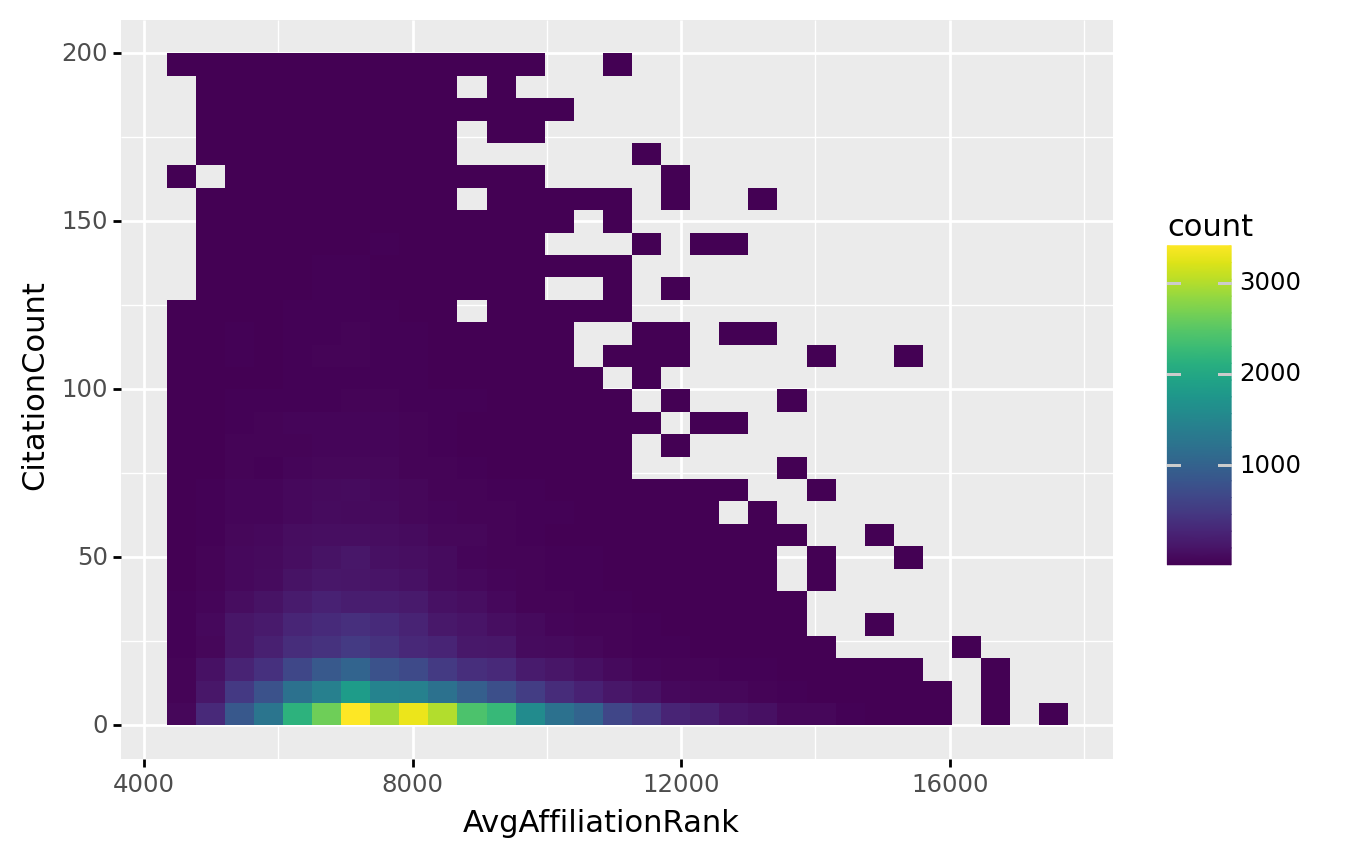

<ggplot: (8751108765573)>

In [5]:
ggplot(aes(x='AvgAffiliationRank', y='CitationCount'), data=data) + stat_bin2d()

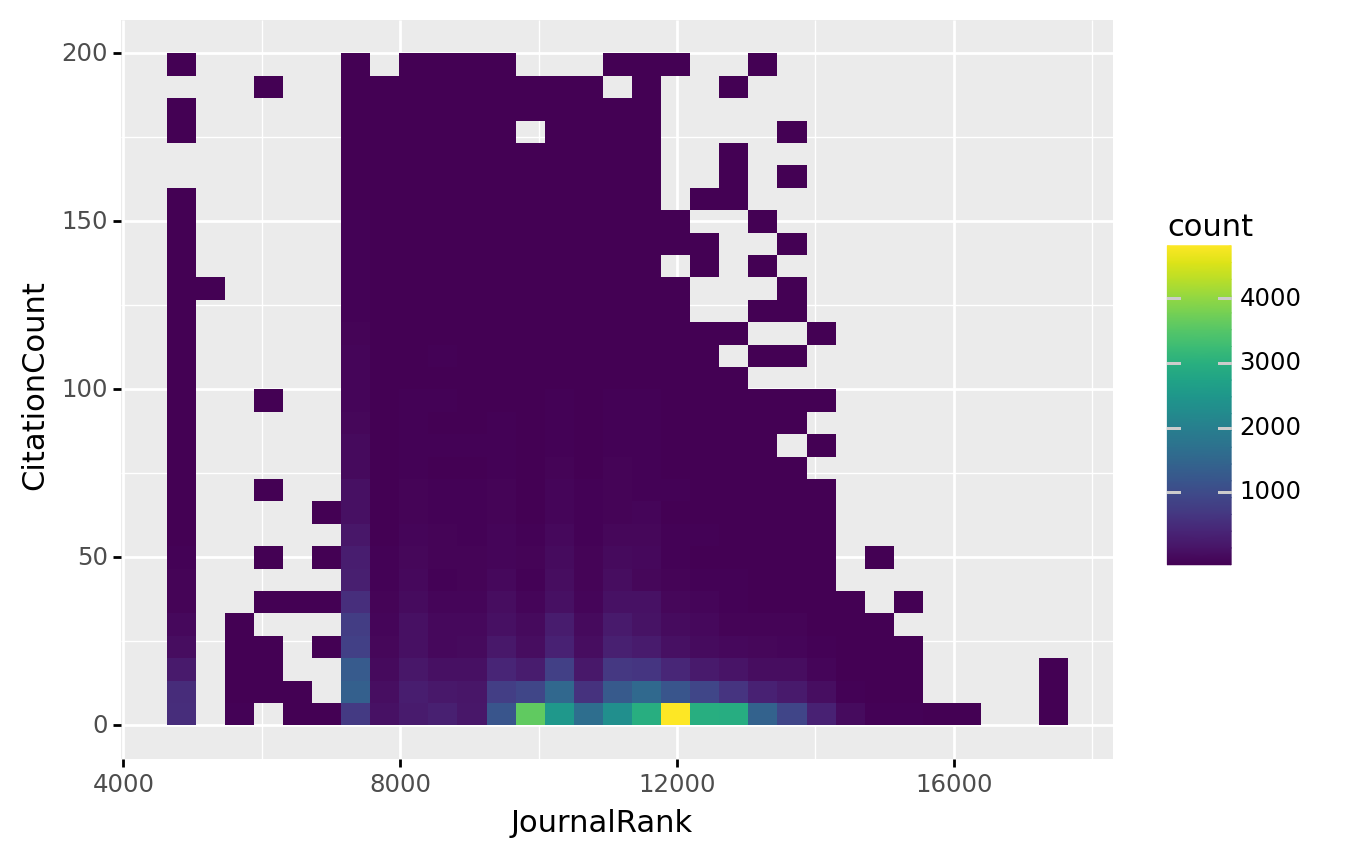

<ggplot: (8751109114390)>

In [6]:
ggplot(aes(x='JournalRank', y='CitationCount'), data=data) + stat_bin2d()

# Why we estimate $f$

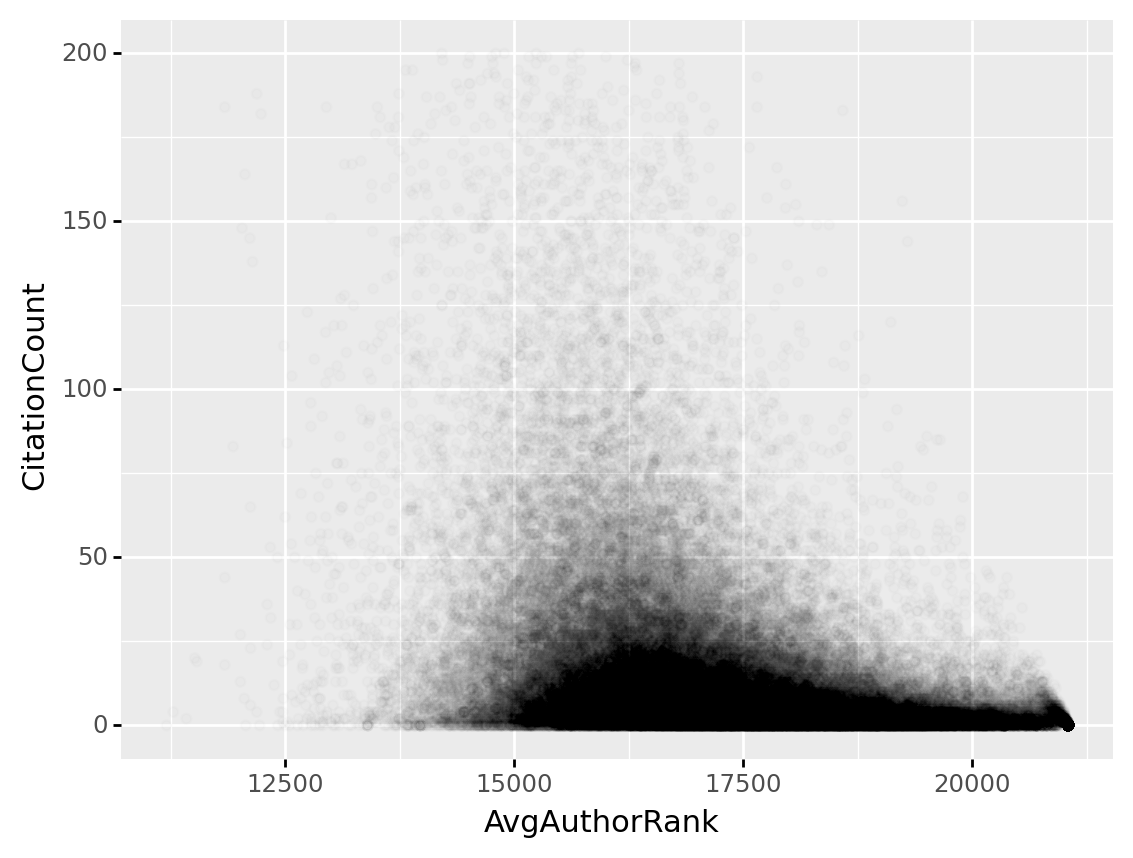

<ggplot: (8751105484011)>

In [7]:
ggplot(aes(x='AvgAuthorRank', y='CitationCount'), data=data) + geom_point(alpha=0.01)

# run simple model

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
X = data[['AvgAuthorRank']]
y = data.CitationCount

In [10]:
lr = LinearRegression().fit(X, y)

In [11]:
lr.intercept_

106.88193453433061

In [12]:
lr.coef_

array([-0.00533859])

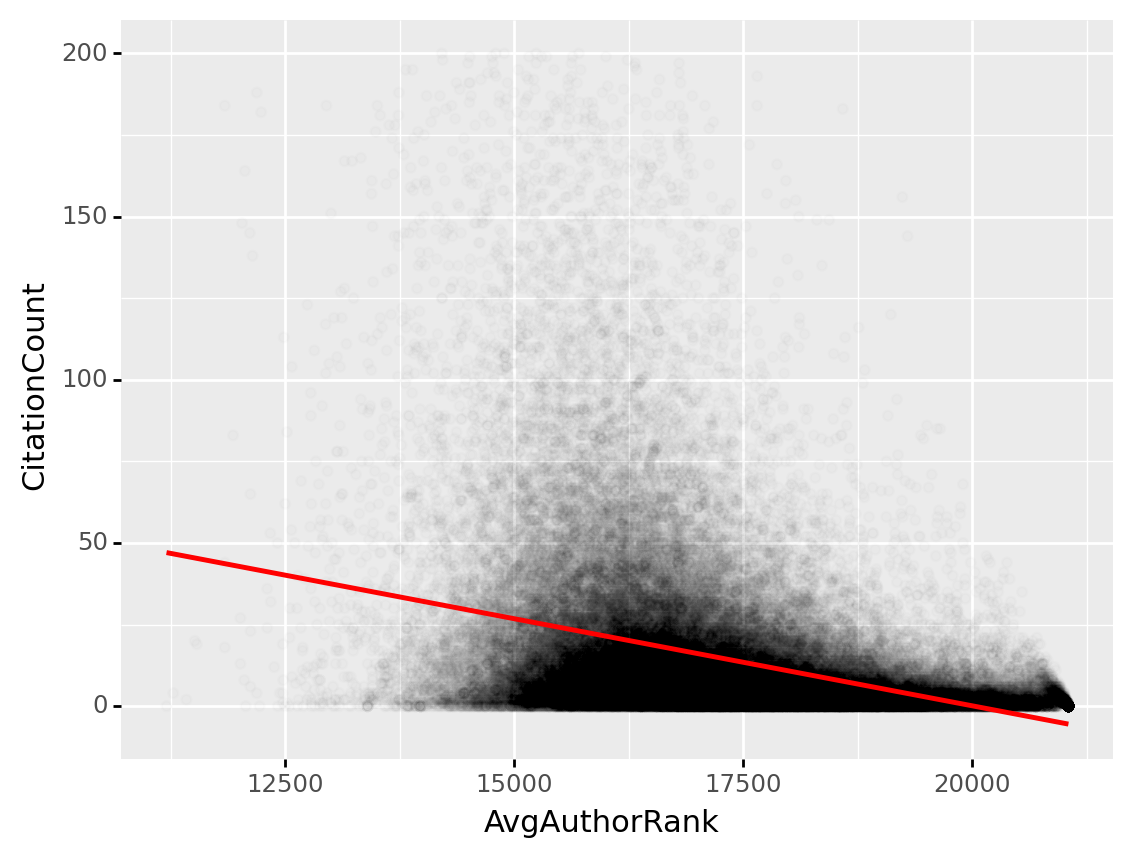

In [13]:
(ggplot(aes(x='AvgAuthorRank', y='CitationCount'), data=data) + geom_point(alpha=0.01) + geom_smooth(color='red')).draw();

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold

In [15]:
X = data[['AvgAuthorRank', 'AvgAffiliationRank', 'JournalRank']].values
y = data.CitationCount.astype('float')

In [16]:
kf = KFold(n_splits=5)

In [17]:
train_sizes_simple, train_scores_simple, test_scores_simple = \
    learning_curve(LinearRegression(), X, y, cv=kf)
train_sizes_complex, train_scores_complex, test_scores_complex = \
    learning_curve(LinearRegression(), PolynomialFeatures(degree=5).fit_transform(X), y, cv=kf, n_jobs=-1)
train_sizes_complex_rf, train_scores_complex_rf, test_scores_complex_rf = \
    learning_curve(RandomForestRegressor(), X, y, cv=kf, n_jobs=-1)

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


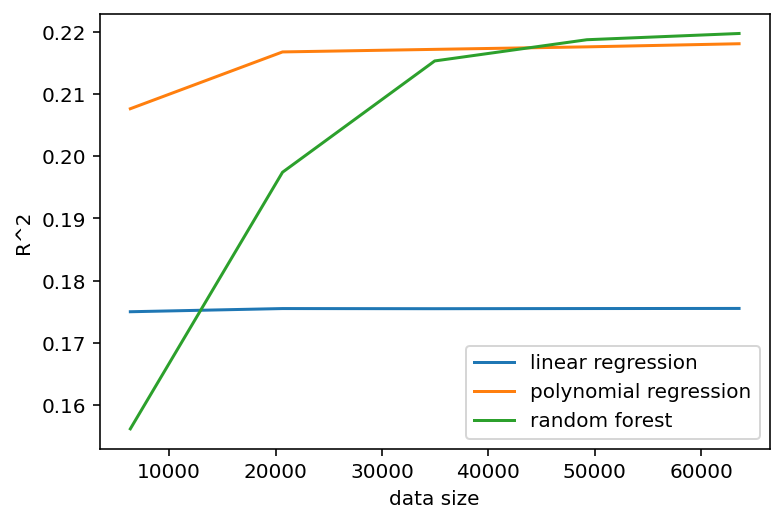

In [18]:
# plt.plot(train_sizes_complex, train_scores_complex.mean(axis=1))
plt.plot(train_sizes_simple, test_scores_simple.mean(axis=1))
plt.plot(train_sizes_complex, test_scores_complex.mean(axis=1))
plt.plot(train_sizes_complex_rf, test_scores_complex_rf.mean(axis=1))
plt.legend(['linear regression', 'polynomial regression', 'random forest'])
plt.xlabel('data size')
plt.ylabel('R^2');

In [19]:
# for a given datasize

In [20]:
performance_np = np.array([[d, cross_val_score(LinearRegression(), 
                PolynomialFeatures(degree=d).fit_transform(X[:1000]), 
                y[:1000], cv=kf, n_jobs=-1).mean()] for d in range(1, 5)])

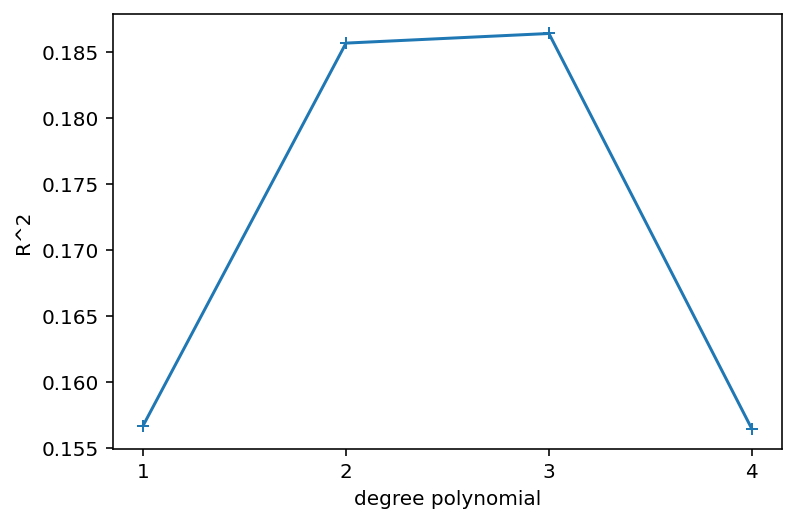

In [21]:
plt.plot(performance_np[:, 0], performance_np[:, 1], '+-');
plt.xlabel('degree polynomial');
plt.ylabel('R^2');
plt.xticks(range(1, 5));

# model selection

In [22]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=10, n_jobs=-1)
model3 = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [23]:
# first we do train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:1000], y[:1000])

In [24]:
# estimate cross validation performance of each model
print("Training")
print("M1 =", model1.fit(X_train, y_train).score(X_train, y_train).mean())
print("M2 =", model2.fit(X_train, y_train).score(X_train, y_train).mean())
print("M3 =", model3.fit(X_train, y_train).score(X_train, y_train).mean())

Training
M1 = 0.1898130329541422
M2 = 0.8262884335770683
M3 = 0.8824568678979834


In [25]:
# estimate cross validation performance of each model
print("Validation")
print("M1 =",cross_val_score(model1, X_train, y_train).mean())
print("M2 =",cross_val_score(model2, X_train, y_train).mean())
print("M3 =",cross_val_score(model3, X_train, y_train).mean())

Validation
M1 = 0.1501159100498658
M2 = -0.058529046526843764
M3 = 0.0854455134538713


In [26]:
model1.fit(X_train, y_train)

LinearRegression()

In [27]:
print("Testing")

model1.score(X_test, y_test)

Testing


0.13235451945711818

In [28]:
data

,AvgAuthorRank,AvgAffiliationRank,JournalRank,CitationCount,HighlyCited
0,16262.500000,6986.000000,9402,17,0
1,17044.857143,4975.285714,9402,65,1
2,16440.000000,5885.875000,9402,13,0
3,15818.750000,6697.750000,9402,47,0
4,15339.769231,6246.076923,9402,8,0
...,...,...,...,...,...
79936,15795.500000,4441.000000,11029,7,0
79937,17387.923077,9013.307692,11029,12,0
79938,15961.125000,4925.000000,11029,53,1
79939,16805.500000,8253.000000,11029,17,0


In [29]:
model1.coef_

array([-0.00412657, -0.00076381, -0.00241729])

# Activity

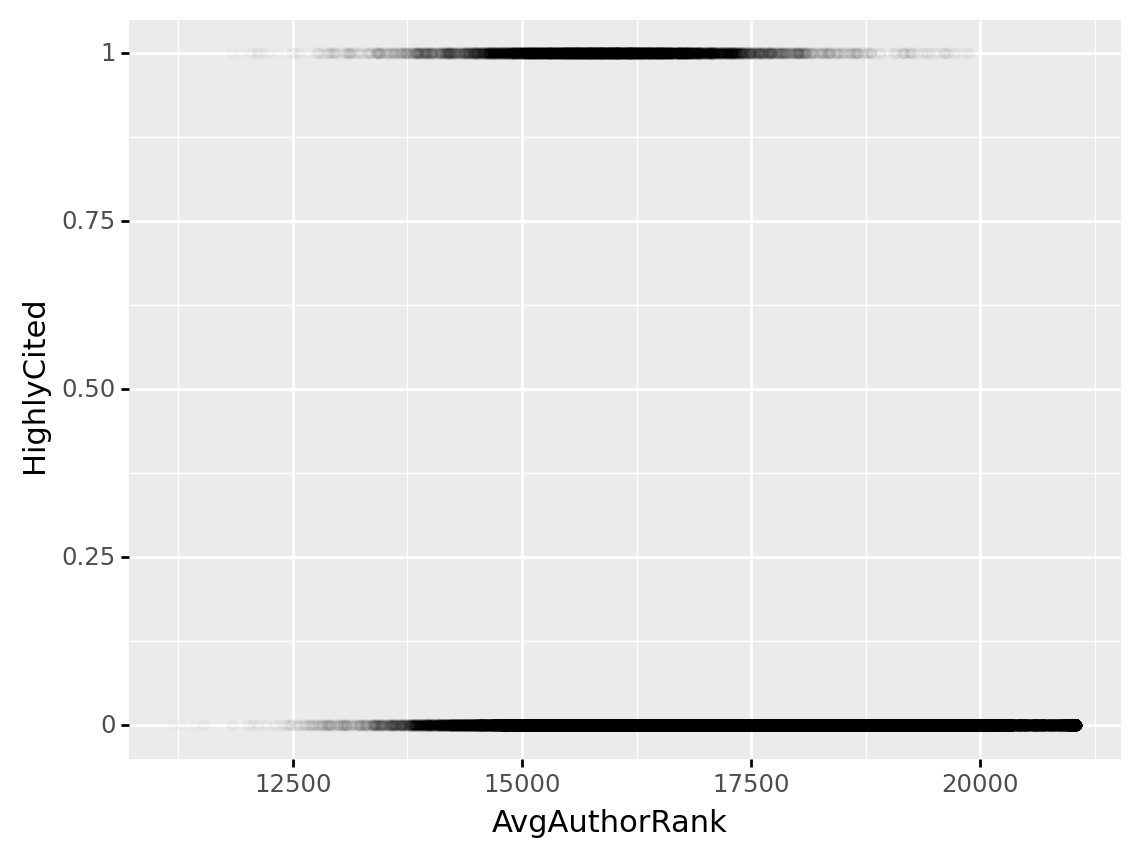

<ggplot: (8779064079568)>

In [6]:
ggplot(aes(x='AvgAuthorRank', y='HighlyCited'), data=data) + geom_point(alpha=0.01)

We are going to perform model selection for predicting highly cited papers

1. Create matrices X and y for the problem (already done below)
1. Split the data into training, validation, and testing (https://scikit-learn.org/)
1. Compare a logistic regression model and a random forest classifier model using AUC under ROC.

In [7]:
# your code here
X = data[['AvgAuthorRank', 'AvgAffiliationRank', 'JournalRank']].values
y = data.HighlyCited.astype('float')